<div style="display: flex;">
    <a href="https://t.me/nsbarsukov" style="margin-right:20px;">
        <img src="https://img.shields.io/badge/Telegram-2CA5E0?style=for-the-badge&logo=telegram&logoColor=white" alt="write-me-telegram"/>
    </a>
    <a href="https://github.com/nsbarsukov/toxic-comments-detector" style="margin-right:20px;">
        <img src="https://img.shields.io/badge/GitHub-100000?style=for-the-badge&logo=github&logoColor=white" alt="Open Github"/>
    </a>
</div>
<div style="display: flex; margin-top: 20px;">
    <a href="https://colab.research.google.com/github/nsbarsukov/toxic-comments-detector/blob/master/models/05weightedCNN%2BNavec.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
</div>

In [1]:
MODEL_NAME = 'weightedCNN_NavecWordEmbeddings_augmentedData'

In [2]:
import os

def check_is_google_colab():
    return 'google.colab' in str(get_ipython())


def prepare_environment():
    if check_is_google_colab():
        from google.colab import drive
        import shutil
        
        drive.mount('/content/gdrive/')

        PATH_TO_TEMP_REPO = '/content/gdrive/My Drive/toxic-comments-repo-temp'

        try:
            shutil.rmtree(PATH_TO_TEMP_REPO)
        except:
            pass

        os.mkdir(PATH_TO_TEMP_REPO)
        
        %cd ./gdrive/My Drive/toxic-comments-repo-temp
        ! git clone https://github.com/nsbarsukov/toxic-comments-detector.git .
        ! pip3 install -q tensorflow_text navec
    else:
        %cd ..

prepare_environment()

/Users/n.barsukov/PycharmProjects/toxic-comments-detector


In [3]:
import sys
import tensorflow as tf
import numpy as np

# local (this repo) imports
from dev import (
    load_cleaned_russian_text_data,
    load_translated_from_english_cleaned_russian_text_data,
    get_class_weights,
    evaluate_model,
    show_tf_model_summary,
    make_sentence_vectorizer,
    get_3d_quartile_words_count,
    early_stopping_cb,
    save_tf_model,
    SEED,
    VALIDATION_SPLIT_PARTITION,
    DEFAULT_BATCH_SIZE,
    DEFAULT_EPOCHS,
)
from wordEmbeddingsLayers import get_navec_word_vectorizer

tf.random.set_seed(SEED)

print('Python version:', sys.version)
print('Tensorflow version:', tf.__version__)

Python version: 3.8.9 (default, Apr  3 2021, 01:50:09) 
[Clang 12.0.0 (clang-1200.0.32.29)]
Tensorflow version: 2.4.1


# Word Vectorizer

In [4]:
X_translated_pretrain, y_translated_pretrain = load_translated_from_english_cleaned_russian_text_data()
X_train, X_test, y_train, y_test = load_cleaned_russian_text_data()

In [5]:
VECTORIZED_SENTENCE_LENGTH = get_3d_quartile_words_count(X_train.flatten())

navec_word_vectorizer, NAVEC_EMBEDDING_DIMENSION = get_navec_word_vectorizer()

navec_sentence_vectorizer = make_sentence_vectorizer(
    vectorizer=navec_word_vectorizer,
    pad_sentence_to_n_words=VECTORIZED_SENTENCE_LENGTH
)

In [6]:
X_translated_pretrain = np.array(list(
    map(navec_sentence_vectorizer, X_translated_pretrain.flatten())
))

X_train = np.array(list(
    map(navec_sentence_vectorizer, X_train.flatten())
))

X_test = np.array(list(
    map(navec_sentence_vectorizer, X_test.flatten())
))

# Build CNN model

In [7]:
from tensorflow.keras import layers, losses

model = tf.keras.Sequential([
    layers.Input(
        shape=(VECTORIZED_SENTENCE_LENGTH, NAVEC_EMBEDDING_DIMENSION,),
        dtype=tf.float32,
        name='Navec_word_embeddings'
    ),
    
    layers.Conv1D(filters=256, kernel_size=5, activation='relu', name='ConvolutionLayer'),
    layers.GlobalMaxPool1D(name='Pooling'),
    
    layers.Dense(units=128, activation='relu', name='FC_Layer_Relu'),
    layers.Dropout(rate=0.5, seed=SEED, name='Regularization'),
    layers.Dense(
        units=1,
        name='FC_Layer_sigmoid',
        activation='sigmoid'
    ),
], name=MODEL_NAME)

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), # from_logits=False, т.к. на выходе activation='sigmoid'
    optimizer='adam',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [8]:
pretrain_history = model.fit(
    x=X_translated_pretrain,
    y=y_translated_pretrain,
    epochs=DEFAULT_EPOCHS,
    batch_size=DEFAULT_BATCH_SIZE,
    validation_split=VALIDATION_SPLIT_PARTITION,
    callbacks=[early_stopping_cb],
)

Epoch 1/10
16/16 [==============================] - 3s 160ms/step - loss: 0.6779 - binary_accuracy: 0.6033 - recall: 0.5658 - precision: 0.6037 - val_loss: 0.5381 - val_binary_accuracy: 0.7395 - val_recall: 0.8502 - val_precision: 0.6904
Epoch 2/10
16/16 [==============================] - 2s 114ms/step - loss: 0.5109 - binary_accuracy: 0.7489 - recall: 0.7740 - precision: 0.7380 - val_loss: 0.4814 - val_binary_accuracy: 0.7665 - val_recall: 0.7136 - val_precision: 0.7901
Epoch 3/10
16/16 [==============================] - 2s 112ms/step - loss: 0.4245 - binary_accuracy: 0.8130 - recall: 0.7984 - precision: 0.8233 - val_loss: 0.4426 - val_binary_accuracy: 0.7865 - val_recall: 0.7554 - val_precision: 0.7985
Epoch 4/10
16/16 [==============================] - 2s 109ms/step - loss: 0.3546 - binary_accuracy: 0.8488 - recall: 0.8410 - precision: 0.8567 - val_loss: 0.4255 - val_binary_accuracy: 0.8005 - val_recall: 0.7768 - val_precision: 0.8089
Epoch 5/10
16/16 [==============================

In [9]:
negative_class_amount, pos_class_amount = np.bincount(y_train)

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=DEFAULT_EPOCHS,
    batch_size=DEFAULT_BATCH_SIZE,
    validation_split=VALIDATION_SPLIT_PARTITION,
    callbacks=[early_stopping_cb],
    class_weight=get_class_weights(pos_class_amount, negative_class_amount),
)

Epoch 1/10
19/19 [==============================] - 2s 104ms/step - loss: 0.4135 - binary_accuracy: 0.8231 - recall: 0.7938 - precision: 0.7130 - val_loss: 0.3241 - val_binary_accuracy: 0.8673 - val_recall: 0.7331 - val_precision: 0.8479
Epoch 2/10
19/19 [==============================] - 2s 106ms/step - loss: 0.2934 - binary_accuracy: 0.8897 - recall: 0.8798 - precision: 0.8092 - val_loss: 0.3044 - val_binary_accuracy: 0.8816 - val_recall: 0.8372 - val_precision: 0.8129
Epoch 3/10
19/19 [==============================] - 2s 96ms/step - loss: 0.2183 - binary_accuracy: 0.9203 - recall: 0.9188 - precision: 0.8552 - val_loss: 0.3727 - val_binary_accuracy: 0.8591 - val_recall: 0.9167 - val_precision: 0.7295
Epoch 4/10
19/19 [==============================] - 2s 97ms/step - loss: 0.2213 - binary_accuracy: 0.9139 - recall: 0.9240 - precision: 0.8371 - val_loss: 0.3432 - val_binary_accuracy: 0.8669 - val_recall: 0.8854 - val_precision: 0.7564
Epoch 5/10
19/19 [==============================] 

# Model evaluation

Accuracy: 90.18%
Recall: 86.58%
Precision: 84.2%
F1-score: 85.37% 



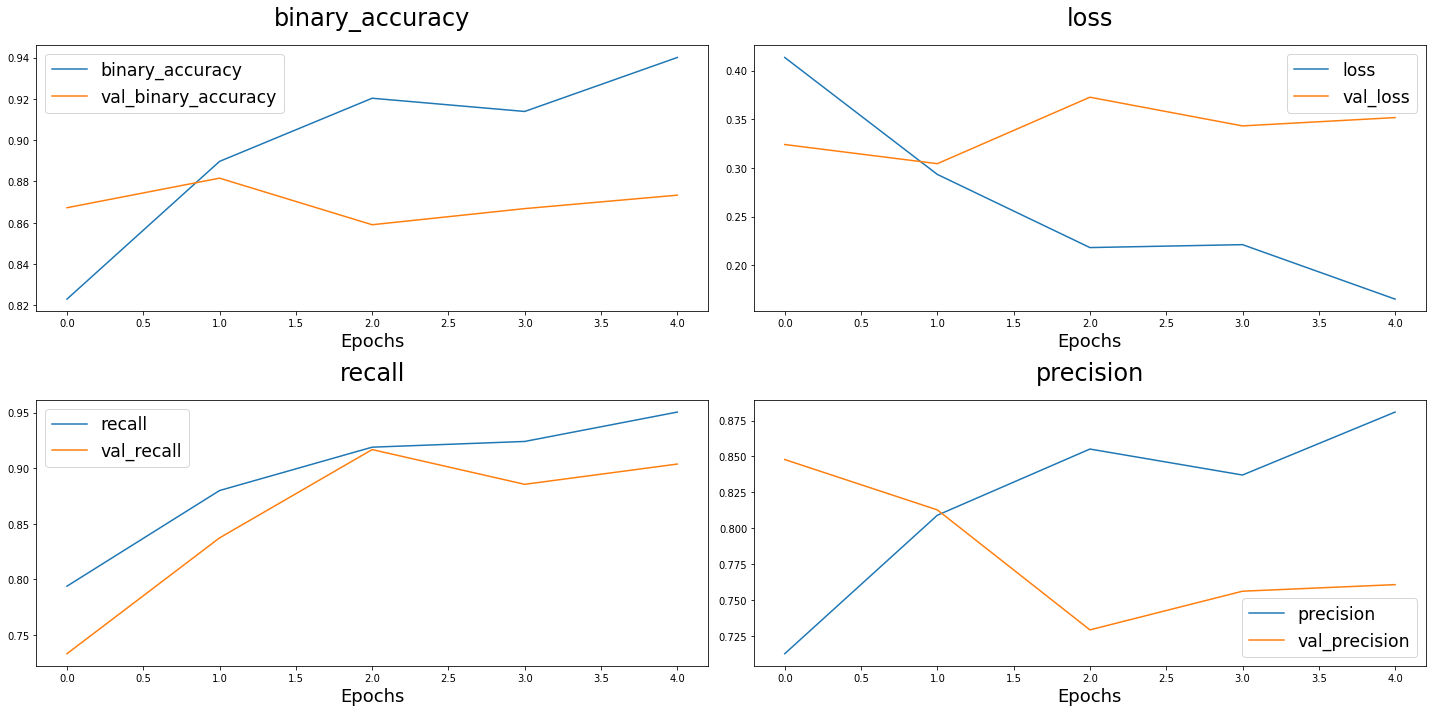

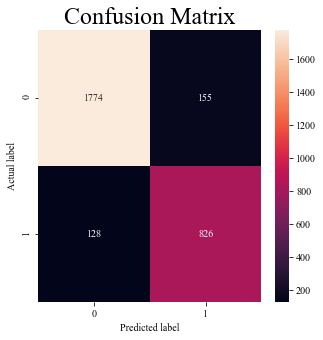

In [10]:
y_test_pred = (model.predict(X_test).flatten() > 0.5) * 1

evaluate_model(y_test, y_test_pred, tf_history_learning=history, model_name=MODEL_NAME)

Model: "weightedCNN_NavecWordEmbeddings_augmentedData"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ConvolutionLayer (Conv1D)    (None, 27, 256)           384256    
_________________________________________________________________
Pooling (GlobalMaxPooling1D) (None, 256)               0         
_________________________________________________________________
FC_Layer_Relu (Dense)        (None, 128)               32896     
_________________________________________________________________
Regularization (Dropout)     (None, 128)               0         
_________________________________________________________________
FC_Layer_sigmoid (Dense)     (None, 1)                 129       
Total params: 417,281
Trainable params: 417,281
Non-trainable params: 0
_________________________________________________________________


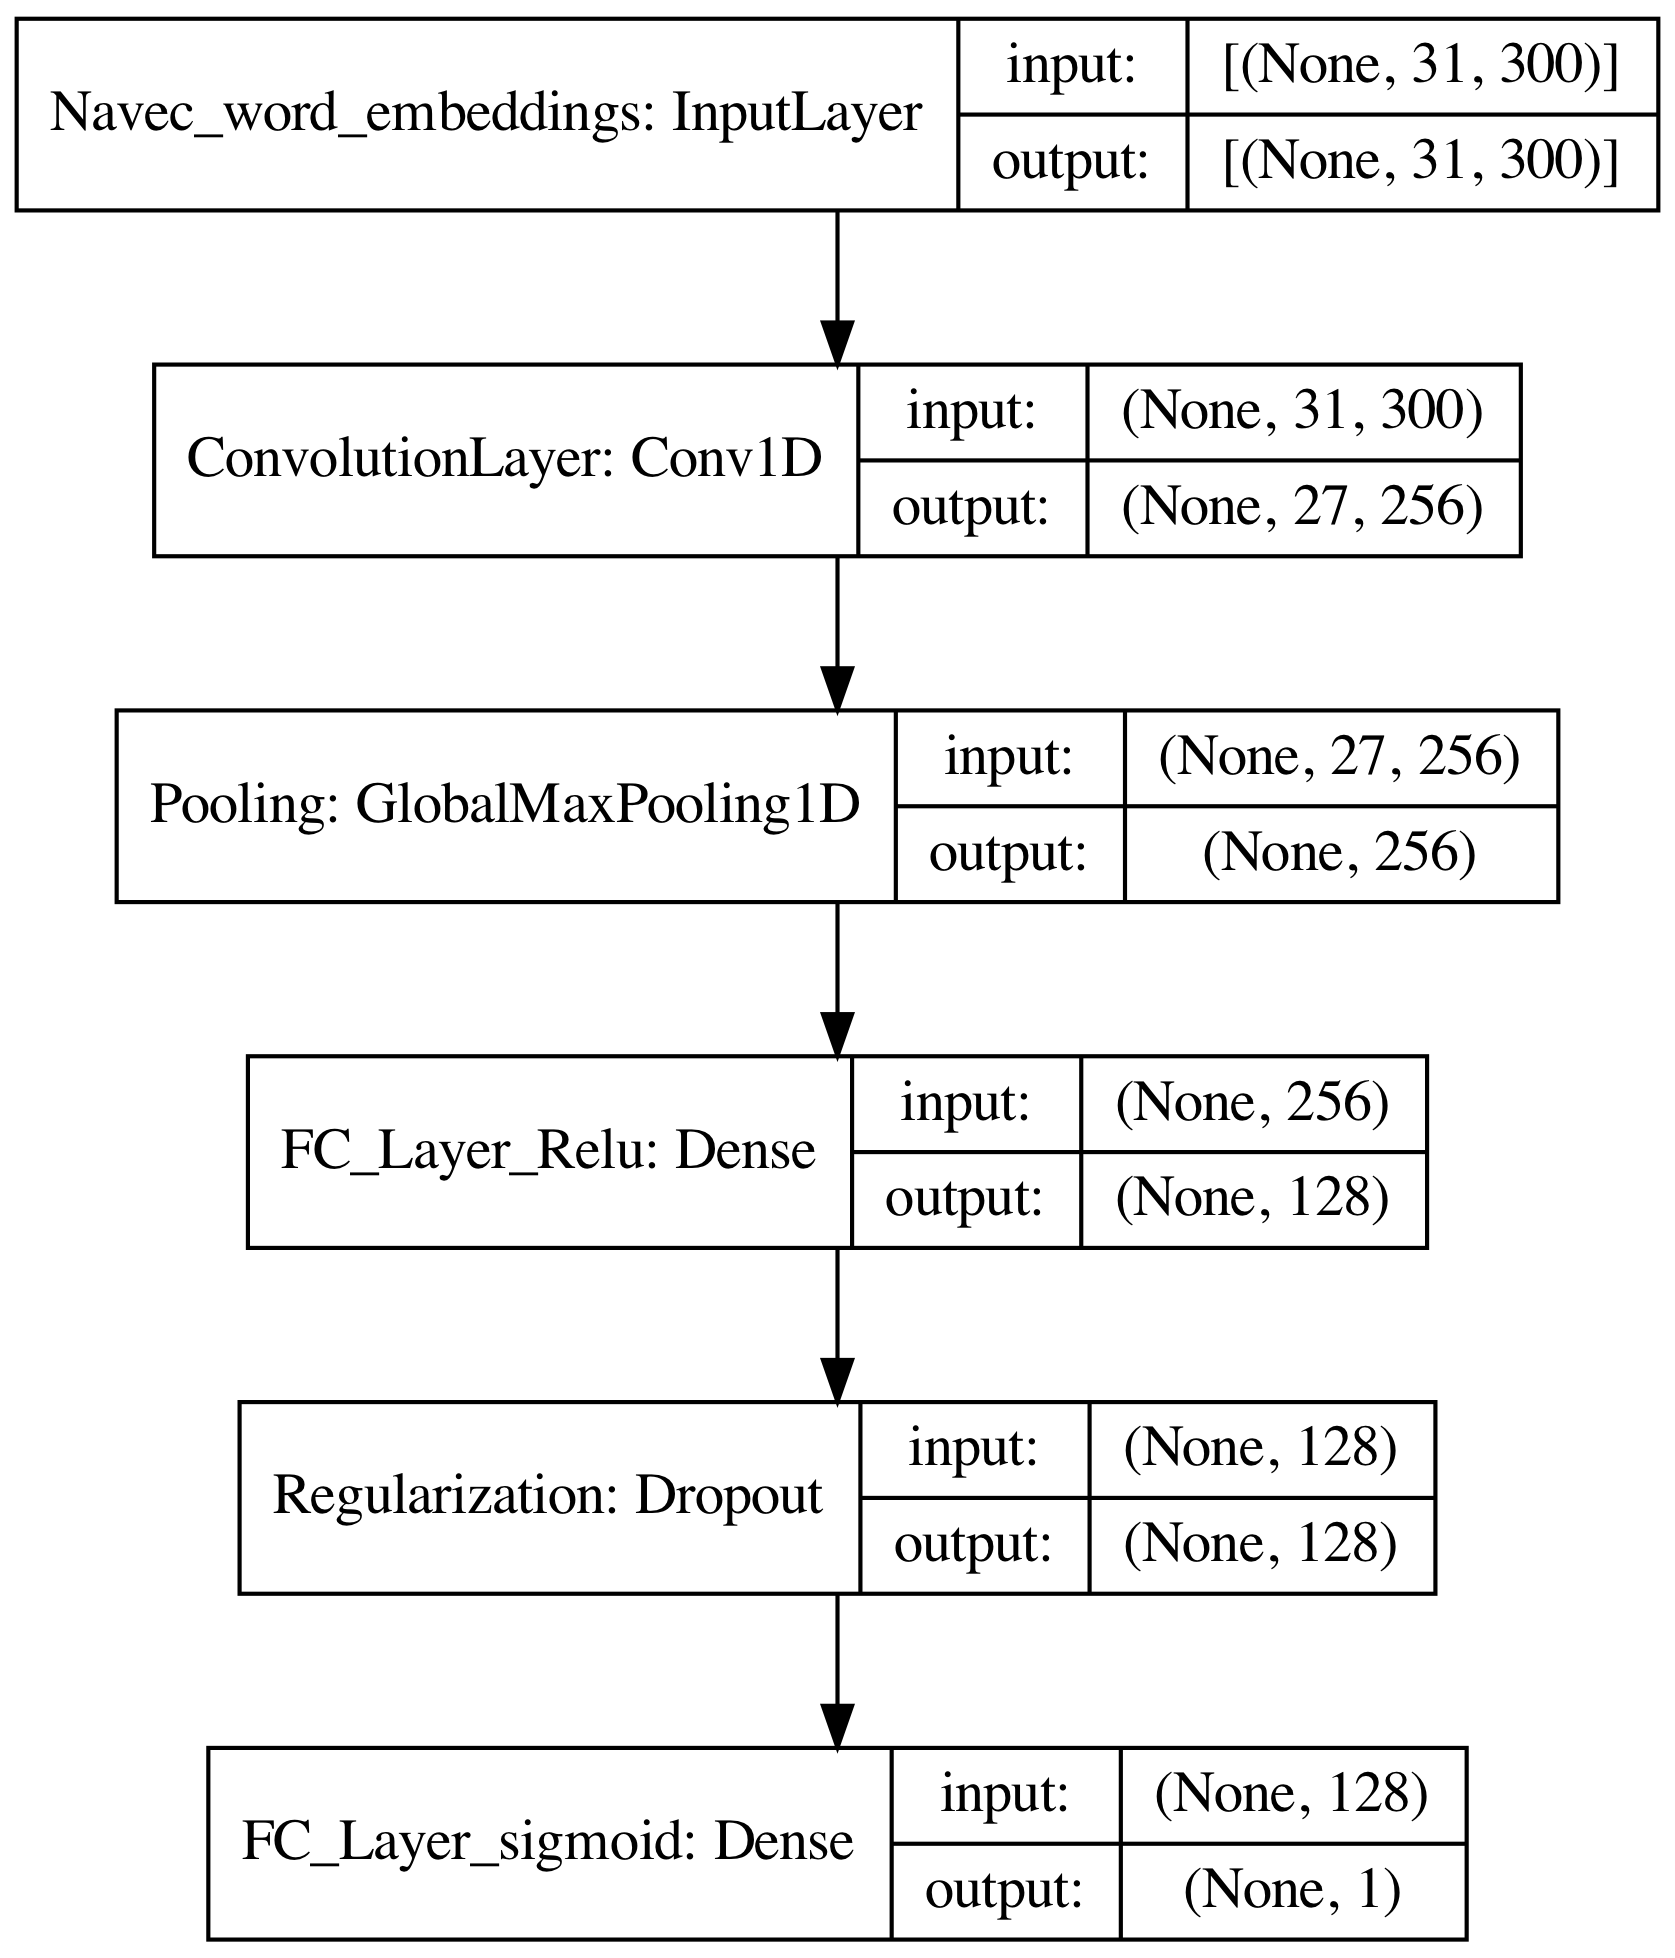

In [11]:
show_tf_model_summary(model)

In [12]:
save_tf_model(model)

INFO:tensorflow:Assets written to: .savedModels/weightedCNN_NavecWordEmbeddings_augmentedData/assets


In [13]:
from dev import DIRECTORY_WITH_SAVED_MODELS
from textPreprocessing import preprocess_text

loaded_model = tf.keras.models.load_model(f'{DIRECTORY_WITH_SAVED_MODELS}/{model.name}')

raw_texts = ['ты чего берега попутал?', 'это правый берег реки, не путай с левым']
preprocessed_texts = np.array(
    list(map(lambda text: navec_sentence_vectorizer(preprocess_text(text)), raw_texts))
)

loaded_model.predict(preprocessed_texts)

array([[0.9456772 ],
       [0.24638516]], dtype=float32)